<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = True
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/sample_data/ham

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [6]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [7]:
def get_weights():
  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= 2.0
  weights[3] *= 2.0
  weights[4] *= 2.0


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4])

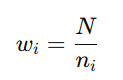

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [8]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [9]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 6:
    # alexnetmulticlass = models.alexnet(weights=None)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Linear(9216, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(),
    # torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    # nn.Softmax(dim=1)
    # )
    # loss_fn = nn.CrossEntropyLoss()

    # return alexnetmulticlass,loss_fn
    return




In [10]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [11]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
        target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
        target = target.to(device)


        input_img = input_img.to(device)
        output = model(input_img.to(device))

        loss = loss_fn(output, target.float())

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,zero_division=1)
        train_recall += recall_score(target,output,zero_division=1)
        train_precision += precision_score(target,output,zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [12]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):
            input_img = input_img.to(device)


            target = torch.unsqueeze(target, 1)
            target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
            target = target.to(device)

            output = model(input_img)
            loss = loss_fn(output, target.float())

            output = torch.sigmoid(output)
            output = (output.cpu().detach().numpy() > 0.5).astype(int)
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,zero_division=1)
            val_recall += recall_score(target,output,zero_division=1)
            val_precision += precision_score(target,output,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [13]:
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}

  patiente = 100
  best_recall = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)

      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")

      if val_recall > best_recall:
        best_recall = val_recall
        patiente = 100
      else:
        patiente -= 1

      if patiente == 0:
        print("Early Sopping")
        break

  wandb.finish()

In [14]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2}
MODEL = architectures['resnet152']

TRAINING = 0.75
VALIDATION = 0.15
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
#FINE_TUNING = [None,models.AlexNet_Weights.IMAGENET1K_V1]
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
extra = 0.4
WEIGHTS = [get_weights()+extra]

learning_rate  = 1e-5

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)

0    5028
1     835
2     824
3     386
4     245
5     106
6      86
Name: count, dtype: int64
7510
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 61.4MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [1.8229647861576397]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.5233218774516532
Accuracy train epoch: 1  train_acc: 0.7926378143133462
F1 train epoch: 1  train_f1: 0.5731227651401266
Recall train epoch: 1  train_recall: 0.7423045984748109


Pèrdua validació epoch: 1  val_loss: 0.4310147473588586
Accuracy val epoch: 1  val_acc: 0.8640625
F1 val epoch: 1  val_f1: 0.6539545681973161
Recall val epoch: 1  val_reall: 0.7064709595959596


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.3775721775090441
Accuracy train epoch: 2  train_acc: 0.8776112185686654
F1 train epoch: 2  train_f1: 0.6884907239694547
Recall train epoch: 2  train_recall: 0.7590750974793525


Pèrdua validació epoch: 2  val_loss: 0.370416724588722
Accuracy val epoch: 2  val_acc: 0.89453125
F1 val epoch: 2  val_f1: 0.6440361015510978
Recall val epoch: 2  val_reall: 0.6062748015873017


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.3251903293614692
Accuracy train epoch: 3  train_acc: 0.8934477756286268
F1 train epoch: 3  train_f1: 0.7327985388419481
Recall train epoch: 3  train_recall: 0.8054439650184333


Pèrdua validació epoch: 3  val_loss: 0.3452491839416325
Accuracy val epoch: 3  val_acc: 0.8873046875
F1 val epoch: 3  val_f1: 0.6609603121551652
Recall val epoch: 3  val_reall: 0.6377559072871574


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.27259141346241567
Accuracy train epoch: 4  train_acc: 0.9145793036750484
F1 train epoch: 4  train_f1: 0.7752524227779481
Recall train epoch: 4  train_recall: 0.8298910663804283


Pèrdua validació epoch: 4  val_loss: 0.3447847224306315
Accuracy val epoch: 4  val_acc: 0.88671875
F1 val epoch: 4  val_f1: 0.7034287156771676
Recall val epoch: 4  val_reall: 0.7340649801587301


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.24753795102872747
Accuracy train epoch: 5  train_acc: 0.9268133462282399
F1 train epoch: 5  train_f1: 0.8058260112999588
Recall train epoch: 5  train_recall: 0.8621451598047345


Pèrdua validació epoch: 5  val_loss: 0.36456165518029593
Accuracy val epoch: 5  val_acc: 0.9052734375
F1 val epoch: 5  val_f1: 0.7436517368188228
Recall val epoch: 5  val_reall: 0.7247023809523809


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.2212508811120023
Accuracy train epoch: 6  train_acc: 0.9311895551257254
F1 train epoch: 6  train_f1: 0.8132829867910623
Recall train epoch: 6  train_recall: 0.8773592955507851


Pèrdua validació epoch: 6  val_loss: 0.3327190016862005
Accuracy val epoch: 6  val_acc: 0.9013671875
F1 val epoch: 6  val_f1: 0.7172998366013073
Recall val epoch: 6  val_reall: 0.6911582341269842


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.18815333624469474
Accuracy train epoch: 7  train_acc: 0.9424323017408124
F1 train epoch: 7  train_f1: 0.8460601815314284
Recall train epoch: 7  train_recall: 0.8994797046924711


Pèrdua validació epoch: 7  val_loss: 0.349397559883073
Accuracy val epoch: 7  val_acc: 0.9017578125
F1 val epoch: 7  val_f1: 0.7259324922153871
Recall val epoch: 7  val_reall: 0.7267564033189036


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.16168346777558326
Accuracy train epoch: 8  train_acc: 0.9529980657640232
F1 train epoch: 8  train_f1: 0.8711261721018336
Recall train epoch: 8  train_recall: 0.9186193947896075


Pèrdua validació epoch: 8  val_loss: 0.3272295380011201
Accuracy val epoch: 8  val_acc: 0.904296875
F1 val epoch: 8  val_f1: 0.7434189211738557
Recall val epoch: 8  val_reall: 0.7560730068542568


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.15224248304804588
Accuracy train epoch: 9  train_acc: 0.9540860735009672
F1 train epoch: 9  train_f1: 0.87398474389987
Recall train epoch: 9  train_recall: 0.9226313284823925


Pèrdua validació epoch: 9  val_loss: 0.32269473117776215
Accuracy val epoch: 9  val_acc: 0.893359375
F1 val epoch: 9  val_f1: 0.7128272870919932
Recall val epoch: 9  val_reall: 0.7593220147907648


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.12618170165001077
Accuracy train epoch: 10  train_acc: 0.9640352998065764
F1 train epoch: 10  train_f1: 0.9008124764300246
Recall train epoch: 10  train_recall: 0.9467644530410491


Pèrdua validació epoch: 10  val_loss: 0.3950870332773775
Accuracy val epoch: 10  val_acc: 0.89609375
F1 val epoch: 10  val_f1: 0.6862737854465797
Recall val epoch: 10  val_reall: 0.7026041666666667


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.107191681679576
Accuracy train epoch: 11  train_acc: 0.9688829787234042
F1 train epoch: 11  train_f1: 0.9183824909327183
Recall train epoch: 11  train_recall: 0.9519531178041818


Pèrdua validació epoch: 11  val_loss: 0.44078266457654536
Accuracy val epoch: 11  val_acc: 0.9009765625
F1 val epoch: 11  val_f1: 0.7009645832860811
Recall val epoch: 11  val_reall: 0.6842476100288601


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.10716105165316704
Accuracy train epoch: 12  train_acc: 0.9695478723404255
F1 train epoch: 12  train_f1: 0.914268156511751
Recall train epoch: 12  train_recall: 0.9523895135597265


Pèrdua validació epoch: 12  val_loss: 0.4171705535845831
Accuracy val epoch: 12  val_acc: 0.91015625
F1 val epoch: 12  val_f1: 0.7294238339275104
Recall val epoch: 12  val_reall: 0.6886780753968254


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.09671925007108044
Accuracy train epoch: 13  train_acc: 0.972147001934236
F1 train epoch: 13  train_f1: 0.9168384267429472
Recall train epoch: 13  train_recall: 0.9572654650314225


Pèrdua validació epoch: 13  val_loss: 0.3751629947219044
Accuracy val epoch: 13  val_acc: 0.9021484375
F1 val epoch: 13  val_f1: 0.7438434829059831
Recall val epoch: 13  val_reall: 0.7607729076479077


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.09291728295465099
Accuracy train epoch: 14  train_acc: 0.9752659574468086
F1 train epoch: 14  train_f1: 0.9291354965571765
Recall train epoch: 14  train_recall: 0.9644591814804582


Pèrdua validació epoch: 14  val_loss: 0.4254074517812114
Accuracy val epoch: 14  val_acc: 0.9091796875
F1 val epoch: 14  val_f1: 0.736651287846141
Recall val epoch: 14  val_reall: 0.6971309072871574


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.07578127034642596
Accuracy train epoch: 15  train_acc: 0.9792553191489362
F1 train epoch: 15  train_f1: 0.9388869988745491
Recall train epoch: 15  train_recall: 0.9684948975374509


Pèrdua validació epoch: 15  val_loss: 0.38501730002462864
Accuracy val epoch: 15  val_acc: 0.915625
F1 val epoch: 15  val_f1: 0.696209217070769
Recall val epoch: 15  val_reall: 0.6639362373737375


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.07937497647598069
Accuracy train epoch: 16  train_acc: 0.9753989361702128
F1 train epoch: 16  train_f1: 0.9306494332247639
Recall train epoch: 16  train_recall: 0.9666917597768664


Pèrdua validació epoch: 16  val_loss: 0.36066654534079134
Accuracy val epoch: 16  val_acc: 0.9109375
F1 val epoch: 16  val_f1: 0.7519322468359814
Recall val epoch: 16  val_reall: 0.8011656746031746


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.07534716042511641
Accuracy train epoch: 17  train_acc: 0.9793882978723404
F1 train epoch: 17  train_f1: 0.9395997899433461
Recall train epoch: 17  train_recall: 0.9701568407951388


Pèrdua validació epoch: 17  val_loss: 0.40398858522530645
Accuracy val epoch: 17  val_acc: 0.924609375
F1 val epoch: 17  val_f1: 0.7753070765019294
Recall val epoch: 17  val_reall: 0.7306423611111112


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.06803487190937108
Accuracy train epoch: 18  train_acc: 0.9809235976789169
F1 train epoch: 18  train_f1: 0.9437396979982446
Recall train epoch: 18  train_recall: 0.9736295265018671


Pèrdua validació epoch: 18  val_loss: 0.39612319227308035
Accuracy val epoch: 18  val_acc: 0.91796875
F1 val epoch: 18  val_f1: 0.7663105430109108
Recall val epoch: 18  val_reall: 0.7440104166666668


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.06107498298181181
Accuracy train epoch: 19  train_acc: 0.981781914893617
F1 train epoch: 19  train_f1: 0.9482834620630293
Recall train epoch: 19  train_recall: 0.9747249204696014


Pèrdua validació epoch: 19  val_loss: 0.37344248924637213
Accuracy val epoch: 19  val_acc: 0.9052734375
F1 val epoch: 19  val_f1: 0.729981801448036
Recall val epoch: 19  val_reall: 0.7332217261904763


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.06132444279724138
Accuracy train epoch: 20  train_acc: 0.9847074468085106
F1 train epoch: 20  train_f1: 0.9513509571678394
Recall train epoch: 20  train_recall: 0.9766159073856198


Pèrdua validació epoch: 20  val_loss: 0.4088441146159312
Accuracy val epoch: 20  val_acc: 0.9099609375
F1 val epoch: 20  val_f1: 0.750658250880564
Recall val epoch: 20  val_reall: 0.7865169552669555


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.04665546062838365
Accuracy train epoch: 21  train_acc: 0.9886968085106383
F1 train epoch: 21  train_f1: 0.967377152507152
Recall train epoch: 21  train_recall: 0.9815971262779772


Pèrdua validació epoch: 21  val_loss: 0.43721425684634596
Accuracy val epoch: 21  val_acc: 0.91640625
F1 val epoch: 21  val_f1: 0.7622942513712639
Recall val epoch: 21  val_reall: 0.757272501803752


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.0485086878513957
Accuracy train epoch: 22  train_acc: 0.9873670212765957
F1 train epoch: 22  train_f1: 0.9556266871827801
Recall train epoch: 22  train_recall: 0.9861091154708177


Pèrdua validació epoch: 22  val_loss: 0.3879651998868212
Accuracy val epoch: 22  val_acc: 0.9216796875
F1 val epoch: 22  val_f1: 0.764018159289541
Recall val epoch: 22  val_reall: 0.731374007936508


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.05481059811712104
Accuracy train epoch: 23  train_acc: 0.9848404255319149
F1 train epoch: 23  train_f1: 0.9533250745322099
Recall train epoch: 23  train_recall: 0.9764317479211098


Pèrdua validació epoch: 23  val_loss: 0.3869640132179484
Accuracy val epoch: 23  val_acc: 0.91875
F1 val epoch: 23  val_f1: 0.7385070782008669
Recall val epoch: 23  val_reall: 0.7215401785714285


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.04948097022864571
Accuracy train epoch: 24  train_acc: 0.9860372340425532
F1 train epoch: 24  train_f1: 0.9519968223448891
Recall train epoch: 24  train_recall: 0.9813709576475537


Pèrdua validació epoch: 24  val_loss: 0.4328105380409397
Accuracy val epoch: 24  val_acc: 0.9248046875
F1 val epoch: 24  val_f1: 0.7722755910347824
Recall val epoch: 24  val_reall: 0.7375267094017095


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.04404545825549421
Accuracy train epoch: 25  train_acc: 0.9877659574468085
F1 train epoch: 25  train_f1: 0.964591932670452
Recall train epoch: 25  train_recall: 0.9820037763654784


Pèrdua validació epoch: 25  val_loss: 0.4429912459163461
Accuracy val epoch: 25  val_acc: 0.9150390625
F1 val epoch: 25  val_f1: 0.7648968066247478
Recall val epoch: 25  val_reall: 0.7437748015873015


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.0386069231745886
Accuracy train epoch: 26  train_acc: 0.989833172147002
F1 train epoch: 26  train_f1: 0.9692555517429718
Recall train epoch: 26  train_recall: 0.9809669644776028


Pèrdua validació epoch: 26  val_loss: 0.3954679184826091
Accuracy val epoch: 26  val_acc: 0.9232421875
F1 val epoch: 26  val_f1: 0.7887789887378704
Recall val epoch: 26  val_reall: 0.7844742063492065


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.037026344926314465
Accuracy train epoch: 27  train_acc: 0.9900265957446809
F1 train epoch: 27  train_f1: 0.9684446548453243
Recall train epoch: 27  train_recall: 0.9860409684877769


Pèrdua validació epoch: 27  val_loss: 0.3876558074261993
Accuracy val epoch: 27  val_acc: 0.920703125
F1 val epoch: 27  val_f1: 0.7821493210521848
Recall val epoch: 27  val_reall: 0.8229989628427129


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.04287956223942022
Accuracy train epoch: 28  train_acc: 0.9884308510638298
F1 train epoch: 28  train_f1: 0.9636715289234052
Recall train epoch: 28  train_recall: 0.9814515980473427


Pèrdua validació epoch: 28  val_loss: 0.44719573482871056
Accuracy val epoch: 28  val_acc: 0.916796875
F1 val epoch: 28  val_f1: 0.7741097336830698
Recall val epoch: 28  val_reall: 0.7721297799422799


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.03720522347015349
Accuracy train epoch: 29  train_acc: 0.9905585106382979
F1 train epoch: 29  train_f1: 0.9688560269042451
Recall train epoch: 29  train_recall: 0.9904237488280041


Pèrdua validació epoch: 29  val_loss: 0.439096453046659
Accuracy val epoch: 29  val_acc: 0.9265625
F1 val epoch: 29  val_f1: 0.7648641440081658
Recall val epoch: 29  val_reall: 0.7679631132756133


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.03730200473937464
Accuracy train epoch: 30  train_acc: 0.9900265957446809
F1 train epoch: 30  train_f1: 0.9678033991337808
Recall train epoch: 30  train_recall: 0.9834904339159658


Pèrdua validació epoch: 30  val_loss: 0.45070661533100065
Accuracy val epoch: 30  val_acc: 0.9185546875
F1 val epoch: 30  val_f1: 0.7605951971369593
Recall val epoch: 30  val_reall: 0.7494419642857143


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.03538119554831745
Accuracy train epoch: 31  train_acc: 0.9902925531914893
F1 train epoch: 31  train_f1: 0.9674732314130593
Recall train epoch: 31  train_recall: 0.9854118222203329


Pèrdua validació epoch: 31  val_loss: 0.42119335307506844
Accuracy val epoch: 31  val_acc: 0.9234375
F1 val epoch: 31  val_f1: 0.7914346376662554
Recall val epoch: 31  val_reall: 0.7877480158730159


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.03333055960866524
Accuracy train epoch: 32  train_acc: 0.9919608317214701
F1 train epoch: 32  train_f1: 0.9733930410313075
Recall train epoch: 32  train_recall: 0.9882637929446441


Pèrdua validació epoch: 32  val_loss: 0.47009060785057954
Accuracy val epoch: 32  val_acc: 0.9287109375
F1 val epoch: 32  val_f1: 0.7879947105590489
Recall val epoch: 32  val_reall: 0.7731646825396825


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.030486624926685336
Accuracy train epoch: 33  train_acc: 0.9914893617021276
F1 train epoch: 33  train_f1: 0.9737732667530786
Recall train epoch: 33  train_recall: 0.9895927949119437


Pèrdua validació epoch: 33  val_loss: 0.40503681579139084
Accuracy val epoch: 33  val_acc: 0.91796875
F1 val epoch: 33  val_f1: 0.7759865593964859
Recall val epoch: 33  val_reall: 0.7861178751803752


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.031573240459212996
Accuracy train epoch: 34  train_acc: 0.9918882978723405
F1 train epoch: 34  train_f1: 0.9750362904556962
Recall train epoch: 34  train_recall: 0.9894511044511045


Pèrdua validació epoch: 34  val_loss: 0.45971289259614423
Accuracy val epoch: 34  val_acc: 0.91796875
F1 val epoch: 34  val_f1: 0.7549149265986367
Recall val epoch: 34  val_reall: 0.7452768585581087


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.030582702015724748
Accuracy train epoch: 35  train_acc: 0.9910904255319148
F1 train epoch: 35  train_f1: 0.9727040108154661
Recall train epoch: 35  train_recall: 0.9886636885573057


Pèrdua validació epoch: 35  val_loss: 0.4131530308404763
Accuracy val epoch: 35  val_acc: 0.92578125
F1 val epoch: 35  val_f1: 0.7978863895499927
Recall val epoch: 35  val_reall: 0.8098338293650795


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.03645042093653985
Accuracy train epoch: 36  train_acc: 0.9893012572533849
F1 train epoch: 36  train_f1: 0.9684359149978361
Recall train epoch: 36  train_recall: 0.987010530840318


Pèrdua validació epoch: 36  val_loss: 0.441471500962507
Accuracy val epoch: 36  val_acc: 0.916796875
F1 val epoch: 36  val_f1: 0.7557858557822804
Recall val epoch: 36  val_reall: 0.7416020611333112


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.029082406490565614
Accuracy train epoch: 37  train_acc: 0.9917553191489362
F1 train epoch: 37  train_f1: 0.9723361368812921
Recall train epoch: 37  train_recall: 0.9860920757729269


Pèrdua validació epoch: 37  val_loss: 0.3932146706429194
Accuracy val epoch: 37  val_acc: 0.9208984375
F1 val epoch: 37  val_f1: 0.7944977612257025
Recall val epoch: 37  val_reall: 0.8035008394383396


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.03261372592285315
Accuracy train epoch: 38  train_acc: 0.9906914893617021
F1 train epoch: 38  train_f1: 0.9725001207913774
Recall train epoch: 38  train_recall: 0.9857832120598078


Pèrdua validació epoch: 38  val_loss: 0.3482998266990762
Accuracy val epoch: 38  val_acc: 0.9263671875
F1 val epoch: 38  val_f1: 0.7713389928896728
Recall val epoch: 38  val_reall: 0.7817765567765569


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.025281627032103293
Accuracy train epoch: 39  train_acc: 0.9934235976789169
F1 train epoch: 39  train_f1: 0.9779420560409954
Recall train epoch: 39  train_recall: 0.9919824383654172


Pèrdua validació epoch: 39  val_loss: 0.3895375034917379
Accuracy val epoch: 39  val_acc: 0.9275390625
F1 val epoch: 39  val_f1: 0.7901689456376958
Recall val epoch: 39  val_reall: 0.8013156114718615


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.026039004231991365
Accuracy train epoch: 40  train_acc: 0.99375
F1 train epoch: 40  train_f1: 0.9804075125483465
Recall train epoch: 40  train_recall: 0.9908323355131866


Pèrdua validació epoch: 40  val_loss: 0.5007617602750543
Accuracy val epoch: 40  val_acc: 0.92265625
F1 val epoch: 40  val_f1: 0.7702698343323345
Recall val epoch: 40  val_reall: 0.7661762716450217


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.024209024914679057
Accuracy train epoch: 41  train_acc: 0.9934840425531914
F1 train epoch: 41  train_f1: 0.9729687657854446
Recall train epoch: 41  train_recall: 0.9907040004912346


Pèrdua validació epoch: 41  val_loss: 0.5404940635344246
Accuracy val epoch: 41  val_acc: 0.9107421875
F1 val epoch: 41  val_f1: 0.7426238334786129
Recall val epoch: 41  val_reall: 0.7011138167388167


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.024942968470202956
Accuracy train epoch: 42  train_acc: 0.9930851063829788
F1 train epoch: 42  train_f1: 0.977191771412608
Recall train epoch: 42  train_recall: 0.9912935409743922


Pèrdua validació epoch: 42  val_loss: 0.5245809487241786
Accuracy val epoch: 42  val_acc: 0.9130859375
F1 val epoch: 42  val_f1: 0.7550284524234798
Recall val epoch: 42  val_reall: 0.7288690476190477


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.03145304626334419
Accuracy train epoch: 43  train_acc: 0.9924927466150871
F1 train epoch: 43  train_f1: 0.9794798746757463
Recall train epoch: 43  train_recall: 0.9908676429953026


Pèrdua validació epoch: 43  val_loss: 0.5149723025097046
Accuracy val epoch: 43  val_acc: 0.91875
F1 val epoch: 43  val_f1: 0.7927800589395985
Recall val epoch: 43  val_reall: 0.7508477633477633


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.02205785945147038
Accuracy train epoch: 44  train_acc: 0.9942214700193425
F1 train epoch: 44  train_f1: 0.9802663621847503
Recall train epoch: 44  train_recall: 0.9889191305148752


Pèrdua validació epoch: 44  val_loss: 0.5153569375688676
Accuracy val epoch: 44  val_acc: 0.9126953125
F1 val epoch: 44  val_f1: 0.7505273372460874
Recall val epoch: 44  val_reall: 0.7189980158730159


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.02696292167876233
Accuracy train epoch: 45  train_acc: 0.9929521276595744
F1 train epoch: 45  train_f1: 0.9750699944135819
Recall train epoch: 45  train_recall: 0.9923195480642288


Pèrdua validació epoch: 45  val_loss: 0.47506368602626026
Accuracy val epoch: 45  val_acc: 0.92578125
F1 val epoch: 45  val_f1: 0.800143529876986
Recall val epoch: 45  val_reall: 0.7797247023809524


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.020441921456082864
Accuracy train epoch: 46  train_acc: 0.9954787234042554
F1 train epoch: 46  train_f1: 0.9850953136834516
Recall train epoch: 46  train_recall: 0.9939443062847318


Pèrdua validació epoch: 46  val_loss: 0.45147585839004023
Accuracy val epoch: 46  val_acc: 0.9248046875
F1 val epoch: 46  val_f1: 0.7997335259017729
Recall val epoch: 46  val_reall: 0.8007564484126984


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.02840876676330462
Accuracy train epoch: 47  train_acc: 0.9916223404255319
F1 train epoch: 47  train_f1: 0.9736242850295319
Recall train epoch: 47  train_recall: 0.9896498418838845


Pèrdua validació epoch: 47  val_loss: 0.5074612233438529
Accuracy val epoch: 47  val_acc: 0.9158203125
F1 val epoch: 47  val_f1: 0.7476372636758668
Recall val epoch: 47  val_reall: 0.7564687049062051


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.01922718349688171
Accuracy train epoch: 48  train_acc: 0.9960106382978723
F1 train epoch: 48  train_f1: 0.9852604793041208
Recall train epoch: 48  train_recall: 0.9948345153664302


Pèrdua validació epoch: 48  val_loss: 0.5417634939658456
Accuracy val epoch: 48  val_acc: 0.920703125
F1 val epoch: 48  val_f1: 0.7832479611891379
Recall val epoch: 48  val_reall: 0.7573164682539683


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.02483960479606894
Accuracy train epoch: 49  train_acc: 0.9928191489361702
F1 train epoch: 49  train_f1: 0.9760927598874118
Recall train epoch: 49  train_recall: 0.9886137503158781


Pèrdua validació epoch: 49  val_loss: 0.5940097291550046
Accuracy val epoch: 49  val_acc: 0.912109375
F1 val epoch: 49  val_f1: 0.7124746576952459
Recall val epoch: 49  val_reall: 0.6785905934343434


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.019131742344495464
Accuracy train epoch: 50  train_acc: 0.9949468085106383
F1 train epoch: 50  train_f1: 0.9813626542820931
Recall train epoch: 50  train_recall: 0.9941521598968407


Pèrdua validació epoch: 50  val_loss: 0.5602486155125916
Accuracy val epoch: 50  val_acc: 0.921875
F1 val epoch: 50  val_f1: 0.7575978198680406
Recall val epoch: 50  val_reall: 0.7118551587301587


train/train_acc,▁▄▄▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
train/train_f1,▁▂▃▄▄▅▆▆▆▆▇▇▇▇▇█▇▇▇██▇██████████████████
train/train_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇▇▇████████████████████
train/train_recall,▁▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇██▇█████████████████████
val/val_acc,▁▄▄▅▅▅▄▄▅▆▆▇▆█▇▆▇▇▇█▇▇▇█▇█▇▇█▇█▇▆▆▇██▇▇▇
val/val_f1,▁▁▂▅▄▅▄▃▄▅▅▃▆▇▆▆▆▆▇▆▇▇▆▆█▇▆█▆██▇▅▆███▆▇▆
val/val_loss,▄▂▂▂▂▂▁▁▃▄▃▄▃▂▃▂▄▄▃▃▅▃▃▄▅▅▃▅▄▄▂▃▆▇▇▇▅▅▆█
val/val_precision,▁▆▄▄▆▄▄▃▃▅▅▇▅▄█▅▅▆▇▆▆▆▅▆▆▇▇▆▆▆▆▅▇█▇█▇▇▆▇
val/val_recall,▄▁▅▄▄▆▃▃▃▆▂▇▅▅▅▆▅▄▅▅█▆▆▅▇▇▅█▅▇▇▆▃▄▅▆▇▅▆▄
train/train_acc,0.99495


In [15]:
print(training.__len__())

NameError: name 'training' is not defined